# Import Library

In [644]:
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import  Embedding, LSTM, Dense, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import string
import pickle

# Import and Load the Dataset

In [645]:
path = "jsonformatter.txt"

with open(path) as content:
  data1 = json.load(content)
# data1

In [646]:
tag = []
patterns = []
responses = {}

#getting all data to list
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    patterns.append(lines)
    tag.append(intent['tag'])

# patterns

In [647]:
for i,j in enumerate(data1['intents']):
    print(i, j['tag'])

0 salam
1 bye
2 fakultas dan program studi
3 Jadwal Pendaftaran
4 Petunjuk Pendaftaran
5 Mahasiswa Baru
6 transfer pindahan
7 RPL
8 Alih Jenjang
9 Fast Track
10 pasca sarjana
11 Beasiswa
12 Program Sarjana
13 Program Profesi Ners
14 Browsur UMMI
15 Rincian Biaya
16 Kontak Kami
17 UMMI
18 Visi, Misi, Tujuan dan Sasaran Universitas Muhammadiyah Sukabumi
19 Struktur Organisasi
20 Pimpinan Universitas
21 Lokasi Kampus
22 Fasilitas
23 Lembaga UPT (Unit Pelaksana Teknis)
24 Lembaga Al-Islam Kemuhammadiyahan
25 Badan Pembina Harian (BPH)
26 Dewan Penyantun
27 Lembaga Penelitian dan Pengabdian Kepada Masyarakat
28 Senat
29 UPT Humas dan PMB
30 UPT Kantor Urusan Internasional dan Language Center
31 UPT Perpustakaan
32 SIAK
33 E-Complent
34 E-Learning
35 ICT Center
36 Helpdesk UMMI
37 Kalender Akademik
38 Pedoman Administrasi Akademik
39 Pedoman Pembayaran
40 Berita
41 Agenda
42 Perpindahan Program Studi atau Fakultas
43 Pindah reguler ke non-reguler
44 pindah kampus
45 Pengunduran Diri
46 KRS
4

In [648]:
# convert to dataframe
data = pd.DataFrame({'patterns':patterns,
                     'tags': tag})
data

,patterns,tags
0,Hai,salam
1,Hi,salam
2,Halo,salam
3,Apa Kabar,salam
4,Selamat Pagi!,salam
...,...,...
422,arti lambang,identitas
423,makna lambang,identitas
424,lagu ummi,mars ummi
425,mars ummi,mars ummi


In [649]:
data.sample(n=10)


,patterns,tags
173,LPPM Singkatan dari?,Lembaga Penelitian dan Pengabdian Kepada Masya...
38,jadwal pendaftaran diadakan kapan?,Jadwal Pendaftaran
119,UMMI adalah?,UMMI
137,Siapa pimpinan tertinggi ummi?,Pimpinan Universitas
326,cara pembayaran menggunakan bank Muamalat?,Pembayaran Muamalat
113,Boleh minta email?,Kontak Kami
229,Saya dari kelas reguler ingin pindah ke non re...,Pindah reguler ke non-reguler
306,tahapan pembayaran menggunakan bank BCA,Pembayaran BCA
66,Alih Jenjang,Alih Jenjang
18,Terima kasih,bye


# Preprocessing Data

### Remove Punctuation and LowerCase

Pada tahap ini semua tanda baca pada "patterns" akan diubah ke lowercase dan punctuantion dihilangkan

In [650]:
import pandas as pd
import string

def data_cleaning(text):
  text = [letters.lower() for letters in text if letters not in string.punctuation]
  text = ''.join(text)
  return text

dirty_text = pd.DataFrame({'Sebelum': patterns})
clean_text = pd.DataFrame({'Sesudah': patterns})

result = pd.concat([dirty_text['Sebelum'], clean_text['Sesudah'].apply(data_cleaning)], axis=1)
result.sample(n=10)


,Sebelum,Sesudah
78,daftar beasiswa untuk calon mahasiswa?,daftar beasiswa untuk calon mahasiswa
385,Sastra Inggris,sastra inggris
257,cara dispensasi,cara dispensasi
196,ICT Center,ict center
352,PJKR,pjkr
55,1,1
235,pindah kampus,pindah kampus
65,4,4
398,TS ummi,ts ummi
406,Fakultas Hukum,fakultas hukum


## Word Normalization
Tahap ini digunakan untuk merubakah kata yang tidak baku menjadi kata baku

In [651]:
# corpus bisa didownload pada link dibawah ini
#!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

In [652]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

print(text_normalize('info'))

informasi


### Stopword Removal
Stopword removal adalah proses penghapusan atau penghilangan kata-kata umum yang tidak memiliki makna khusus atau tidak memberikan kontribusi signifikan dalam pemrosesan teks atau analisis NLP (Natural Language Processing). Stopword biasanya terdiri dari kata-kata seperti "ada", "di", "dan", "yang", dan sebagainya. Kata-kata ini muncul secara berulang dalam teks dan tidak memberikan informasi yang berguna dalam pemahaman konten.

In [653]:
#Stopword download from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MRizky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [654]:
len(stopwords_ind)

758

In [655]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:10]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [656]:
# Menambahkan kata dalam stopword
more_stopword = ['kak', 'informasi', "tentang", "terkait", "sih", "ngapain", "dipenuhi", "aja", "dah", "ya", "ummi", "izin", "guna", "kan", "gak", "gk"]
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

clean_text['Sesudah'] = clean_text['Sesudah'].apply(remove_stop_words)
result = pd.concat([dirty_text['Sebelum'], clean_text['Sesudah']], axis=1)
result.sample(n=10)

,Sebelum,Sesudah
122,universitas muhammadiyah sukabumi,universitas muhammadiyah sukabumi
272,cara kembali kuliah,kuliah
188,Apa visi dan misi ILC?,Apa visi misi ILC?
222,syarat yang diperlukan agar bisa pindah progra...,syarat pindah program studi
218,kegiatan yang akan dilakukan,kegiatan
93,sarjana,sarjana
47,bagaimana cara melakukan pendaftaran secara on...,pendaftaran online?
337,pendidikan informasi,pendidikan
79,Bagaimana cara mendapatkan beasiswa?,Bagaimana beasiswa?
101,Berapa biaya untuk kelas reguler dan non reguler?,Berapa biaya kelas reguler non reguler?


### Stemming
Stemming adalah proses mengubah kata-kata menjadi bentuk dasarnya (stem) dengan menghapus awalan atau akhiran kata. untuk melakukan stemming, disini saya menggunakan library sastrawi

In [657]:
!pip -q install sastrawi


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [658]:
#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

clean_text['Sesudah'] = clean_text['Sesudah'].apply(stemming)
result = pd.concat([dirty_text['Sebelum'], clean_text['Sesudah']], axis=1)
result.sample(n=5)


,Sebelum,Sesudah
418,arti logo ummi,arti logo
236,saya ingin pindah dari ummi gmna caranya?,pindah gmna cara
227,cara melakukan pindah prodi,pindah prodi
221,bagaimana cara melakukan pindah program progra...,pindah program program studi
266,syarat melakukan cuti,syarat cuti


In [659]:
def text_preprocessing_process(text):
  text = data_cleaning(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [660]:
data['patterns'] = data['patterns'].apply(text_preprocessing_process)
data

,patterns,tags
0,hai,salam
1,hi,salam
2,halo,salam
3,kabar,salam
4,selamat pagi,salam
...,...,...
422,arti lambang,identitas
423,makna lambang,identitas
424,lagu,mars ummi
425,mars,mars ummi


### Tokenize
Tokenizer mengidentifikasi dan memisahkan teks menjadi token-token yang dapat diolah lebih lanjut. Ini dapat berupa tokenisasi berbasis kata, di mana teks dipisahkan menjadi kata-kata individual, atau tokenisasi berbasis sub-kata, di mana teks dipisahkan menjadi unit-unit yang lebih kecil seperti akar kata atau bagian-bagian kata.

### Sequence and Padding
- Sequence (urutan) merujuk pada representasi linier dari teks atau urutan kata dalam bentuk vektor. Dalam pemrosesan bahasa alami, teks sering kali dipecah menjadi urutan kata atau token, dan urutan ini dapat dianggap sebagai rangkaian langkah yang harus diikuti dalam pemodelan dan analisis teks.
- Padding adalah proses menambahkan nilai khusus (biasanya nilai nol) ke urutan teks sehingga semua urutan memiliki panjang yang sama. Ini diperlukan karena teks biasanya memiliki panjang yang berbeda-beda, sementara banyak model pemrosesan bahasa alami memerlukan masukan dengan ukuran yang seragam. Dengan padding, teks yang lebih pendek diisi dengan nilai nol hingga mencapai panjang yang diinginkan.

In [661]:
#tokenize

tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

# Get the word index dictionary
word_index = tokenizer.word_index

word_index


{'program': 1,
 'bayar': 2,
 'daftar': 3,
 'studi': 4,
 'bank': 5,
 'pindah': 6,
 'fakultas': 7,
 'kuliah': 8,
 'beasiswa': 9,
 'kampus': 10,
 'tahap': 11,
 'visi': 12,
 'misi': 13,
 'tugas': 14,
 'reguler': 15,
 'surat': 16,
 'biaya': 17,
 'lembaga': 18,
 'muhammadiyah': 19,
 'didik': 20,
 'non': 21,
 'akademik': 22,
 'universitas': 23,
 'sukabumi': 24,
 'sedia': 25,
 'jurus': 26,
 'sarjana': 27,
 'kip': 28,
 'kelas': 29,
 'syarat': 30,
 'administrasi': 31,
 'ilmu': 32,
 'mahasiswa': 33,
 'upt': 34,
 'dewan': 35,
 'santun': 36,
 'pmb': 37,
 'terang': 38,
 'jadwal': 39,
 'semester': 40,
 'rektor': 41,
 'fasilitas': 42,
 'kemuhammadiyahan': 43,
 'bph': 44,
 'lppm': 45,
 'aktif': 46,
 'ijazah': 47,
 'paja': 48,
 'manajemen': 49,
 'retail': 50,
 'selamat': 51,
 'pagi': 52,
 'terima': 53,
 '1': 54,
 'transfer': 55,
 'profesi': 56,
 'ners': 57,
 'mana': 58,
 'hubung': 59,
 'struktur': 60,
 'organisasi': 61,
 'wakil': 62,
 'al': 63,
 'islam': 64,
 'humas': 65,
 'giat': 66,
 'undur': 67,
 'kr

In [662]:
daftar =  dict((value, key) for (key, value) in tokenizer.word_index.items())
daftar

{1: 'program',
 2: 'bayar',
 3: 'daftar',
 4: 'studi',
 5: 'bank',
 6: 'pindah',
 7: 'fakultas',
 8: 'kuliah',
 9: 'beasiswa',
 10: 'kampus',
 11: 'tahap',
 12: 'visi',
 13: 'misi',
 14: 'tugas',
 15: 'reguler',
 16: 'surat',
 17: 'biaya',
 18: 'lembaga',
 19: 'muhammadiyah',
 20: 'didik',
 21: 'non',
 22: 'akademik',
 23: 'universitas',
 24: 'sukabumi',
 25: 'sedia',
 26: 'jurus',
 27: 'sarjana',
 28: 'kip',
 29: 'kelas',
 30: 'syarat',
 31: 'administrasi',
 32: 'ilmu',
 33: 'mahasiswa',
 34: 'upt',
 35: 'dewan',
 36: 'santun',
 37: 'pmb',
 38: 'terang',
 39: 'jadwal',
 40: 'semester',
 41: 'rektor',
 42: 'fasilitas',
 43: 'kemuhammadiyahan',
 44: 'bph',
 45: 'lppm',
 46: 'aktif',
 47: 'ijazah',
 48: 'paja',
 49: 'manajemen',
 50: 'retail',
 51: 'selamat',
 52: 'pagi',
 53: 'terima',
 54: '1',
 55: 'transfer',
 56: 'profesi',
 57: 'ners',
 58: 'mana',
 59: 'hubung',
 60: 'struktur',
 61: 'organisasi',
 62: 'wakil',
 63: 'al',
 64: 'islam',
 65: 'humas',
 66: 'giat',
 67: 'undur',
 68:

In [663]:
#applying padding
trunc_type='post'
padding_type='post'
maxlen=7

x_train = pad_sequences(train, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

#encoding the methods
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

# print("\nSequences = " , train)
# print(x_train)
# print(le)
# print(y_train)

In [664]:
print("Sequences = " , train[4])
print("Artinya = ", '[',daftar[61], ', ',daftar[194],']')

Sequences =  [51, 52]
Artinya =  [ organisasi ,  jumpa ]


In [665]:
print(x_train)

[[179   0   0 ...   0   0   0]
 [180   0   0 ...   0   0   0]
 [181   0   0 ...   0   0   0]
 ...
 [286   0   0 ...   0   0   0]
 [178   0   0 ...   0   0   0]
 [178  19   0 ...   0   0   0]]


In [666]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [667]:
vocabulary = len(tokenizer.word_index)
print('number of unique words : ', vocabulary)
output_length = le.classes_.shape[0]
print('output length', output_length)

number of unique words :  286
output length 101


# Build the Model

In [668]:
model = Sequential([
    Embedding(input_dim=vocabulary+1, output_dim=10, input_length=input_shape),
    Bidirectional(LSTM(10)),
    Flatten(),
    Dense(output_length, activation='softmax')
])

In [669]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 7, 10)             2870      
                                                                 
 bidirectional_15 (Bidirecti  (None, 20)               1680      
 onal)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 101)               2121      
                                                                 
Total params: 6,671
Trainable params: 6,671
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [670]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.06:
            print("\nReached 0.01 loss so stop training!")
            # Stop training once the above condition is met
            self.model.stop_training = True

In [671]:
import tensorflow as tf
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [672]:
train = model.fit(x_train, y_train, epochs=500, callbacks=myCallback())

Epoch 1/500


14/14 [==============================] - 6s 8ms/step - loss: 4.6136 - accuracy: 0.0094
Epoch 2/500
14/14 [==============================] - 0s 11ms/step - loss: 4.6079 - accuracy: 0.0562
Epoch 3/500
14/14 [==============================] - 0s 12ms/step - loss: 4.6024 - accuracy: 0.0562
Epoch 4/500
14/14 [==============================] - 0s 10ms/step - loss: 4.5948 - accuracy: 0.0492
Epoch 5/500
14/14 [==============================] - 0s 10ms/step - loss: 4.5851 - accuracy: 0.0351
Epoch 6/500
14/14 [==============================] - 0s 10ms/step - loss: 4.5703 - accuracy: 0.0351
Epoch 7/500
14/14 [==============================] - 0s 16ms/step - loss: 4.5473 - accuracy: 0.0328
Epoch 8/500
14/14 [==============================] - 0s 10ms/step - loss: 4.5117 - accuracy: 0.0328
Epoch 9/500
14/14 [==============================] - 0s 10ms/step - loss: 4.4707 - accuracy: 0.0328
Epoch 10/500
14/14 [==============================] - 0s 14ms/step - loss: 4.4368 - accuracy: 0.0445
Epoch 11/500

# Evaluate the Result

In [673]:
loss, accuracy = model.evaluate(x_train, y_train)
print('Loss:', loss)
print('Accuracy:', accuracy)

14/14 [==============================] - 1s 4ms/step - loss: 0.0608 - accuracy: 0.9930
Loss: 0.06082483381032944
Accuracy: 0.9929742217063904


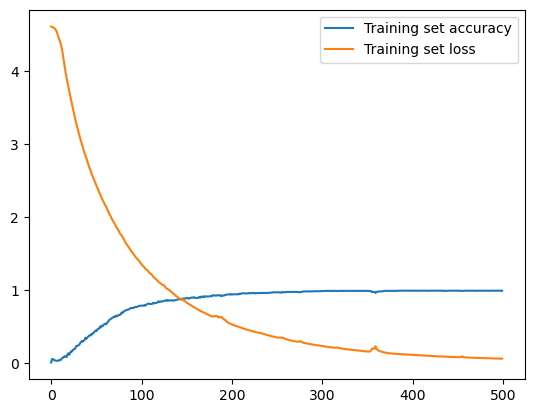

In [674]:
#Model Analysis
plt.plot(train.history['accuracy'], label = 'Training set accuracy')
plt.plot(train.history['loss'], label = 'Training set loss')
plt.legend()

# Inference

In [675]:
#testing
import random
import numpy as np
import string

data_uji = []
hasil_prediksi=[]
print("Selamat datang, ada yang ingin ditanyakan?")
while True:
  texts_p = []
  prediction_input = input('you : ')
  data_uji.append(prediction_input)
  print("input : ",prediction_input)
  #removing punctuation
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_input = text_preprocessing_process(prediction_input)
  texts_p.append(prediction_input)
  

  print("text_p",texts_p)
  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  print("p1",prediction_input)
  prediction_input = np.array(prediction_input).reshape(-1)
  print('p2',prediction_input)
  prediction_input = pad_sequences([prediction_input],input_shape, padding=padding_type, truncating=trunc_type)
  print('p3',prediction_input)


  #output
  output = model.predict(prediction_input)
  max_prob = max(model.predict(prediction_input))
  # print('max_prob', max_prob)
  # print('out1',output)
  max_idx = np.argmax(output)
  # print('maxidx', max_idx)
  output = output.argmax()
  print('out',output)
  response_tag = le.inverse_transform([output])[0]
  #finding the right tag and predicting
  hasil_prediksi.append(response_tag)
  if sum(np.array(prediction_input).reshape(-1)) < 1:
    print("Maaf saya tidak mengerti")
  else:
    print(response_tag)
    print("answer : " ,random.choice(responses[response_tag]))
  if response_tag == 'bye':
    break






Selamat datang, ada yang ingin ditanyakan?
input :  makasi
text_p ['makas']
p1 [[]]
p2 []
p3 [[0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 30ms/step
out 83
Maaf saya tidak mengerti
input :  makasih
text_p ['terimakasih']
p1 [[110]]
p2 [110]
p3 [[110   0   0   0   0   0   0]]
1/1 [==============================] - 0s 36ms/step
out 88
bye
answer :  Sampai jumpa lagi yaa


In [676]:
data_uji1 = ["Bagaimana proses pendaftaran untuk kuliah disini", "Apa persyaratan yang harus dipenuhi untuk mendaftar", "Bagaimana proses pendaftaran kuliah di ummi?", "Bagaimana cara mendapatkan informasi tentang proses pendaftaran kuliah di ummi?","Apakah ada batas waktu pendaftaran untuk kuliah di ummi?", "Bagaimana cara melakukan pembayaran  di UMMI?", "Apa saja metode pembayaran yang tersedia yang ada di UMMI?", "Apakah bisa melakukan pembayaran melalui bank BSI? Bagaimana caranya?", "Bagaimana cara pembayaran perkuliahan menggunakan metode transfer bank di UMMI?",
"Apakah di UMMI menyediakan pembayaran angsuran untuk perkuliahan?", "Apa saja persyaratan untuk melakukan perpindahan prodi di UMMI?", "Bagaimana tahapan untuk melakukan perpindahan program studi?","Selain pindah program studi apakah juga bisa pindah fakultas?", "Apakah ada batasan waktu atau semester tertentu untuk melakukan perpindahan prodi/kampus di UMMI?", "Syarat apa saja yang diperlukan agar bisa pindah kampus?", "Bagaimana cara mengajukan beasiswa di UMMI?", "Apa saja jenis beasiswa yang tersedia di UMMI?", "Bagaimana cara mengajukan Beasiswa KIP di UMMI", "Apakah ada beasiswa khusus untuk mahasiswa yang berasal dari latar belakang ekonomi kurang mampu, seperti Beasiswa KIP (Kartu Indonesia Pintar)?", "Kalo dapet beasiswa dapet potongannya berapa?", "kak kalau misalnya udah ditahap menunggu ujian masih bisa ganti prodi gak kak?","saya dapat nilai ujian terbesar di sekolah, apakah bisa mengajukan beasiswa?", "bagaimana cara melakukan pembayaran lewat BCA", "bagaimana cara melakukan pembayaran?","bagaimana cara melakukan pendaftaran?", "penyetaraan jurusannya apa saja?", "bagaimana cara melakukan transfer bank BNI?", "di ummi ada beasiswa non akademik kriterianya apa saja?", "kak pembayaran melalui bank BCA bagaimana caranya?", "kalo beasiswa dapet potongan berapa?", "untuk pendaftaran online bagaimana caranya ya kak?", "apakah masih ada beasiswa untuk alumni muhammadiyah?", "di ummi menerima beasiswa KIP gak? kalo menerima bagaimana langkah-langkahnya?", "tahapan pendaftaran beasiswa KIP bagaimana?", "kalo pembayaran melalui dana bagaimana caranya?", "biaya pendaftaran untuk mahasiswa baru berapa ya kak?", "biaya pendaftaran secara keseluruhan berapa?", "saya ingin ganti pilihan jurusan saya, bisa ganti gak?", "boleh saya tau biaya kuliah non reguler kak?", "aku mau tanya seputar pendaftaran, gimana caranya?", "bagaimana tahapan untuk perpindahan program studi?", "mau tanya boleh? kalo uang semester 1 bisa dicicil atau harus langsung semua?", "kalo kelas non reguler itu bagaimana?", "kalo biaya pendidikan itu bayarnya bisa bertahap gak?", "apakah sekarang tersedia beasiswa peringkat kelas?", "boleh minta info rincian biaya persemeternya?", "izin bertanya mengenai informasi penggunaan kip di ummi?", "kalo di ummi bisa menggunakan KIP kuliah?", "untuk biaya perkuliahan itu bagaimana?"]

jawaban = ['Petunjuk Pendaftaran', 'Petunjuk Pendaftaran','Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Jadwal Pendaftaran', 'Pedoman Pembayaran', 'Pedoman Pembayaran', 'Pembayaran BSI', 'Pedoman Pembayaran', 'pembayaran cicil', 'Perpindahan Program Studi atau Fakultas', "Perpindahan Program Studi atau Fakultas", "Perpindahan Program Studi atau Fakultas", "Perpindahan Program Studi atau Fakultas", "pindah kampus","Beasiswa", "Beasiswa", "KIP", "KIP","Beasiswa", "Perpindahan Program Studi", "Beasiswa", "Pembayaran BCA", "Pedoman Pembayaran", "Petunjuk Pendaftaran", "RPL", "Pembayaran BNI", "Beasiswa", "Pembayaran BCA", "Beasiswa", "Petunjuk Pendaftaran", "Beasiswa","KIP", "KIP", "Pembayaran Dana", "Rincian Biaya", "Rincian Biaya", "Perpindahan Program Studi atau Fakultas", "Rincian Biaya", "Petunjuk Pendaftaran", "Perpindahan Program Studi atau Fakultas", "pembayaran cicil", 'non-reg', "pembayaran cicil", "Beasiswa", "Rincian Biaya", "KIP", "KIP", "Rincian Biaya"]

In [677]:
def prediksi(pred):
    text_p = []
    prediction_input = pred
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    prediction_input = text_preprocessing_process(prediction_input)
    text_p.append(prediction_input)
    

    prediction_input = tokenizer.texts_to_sequences(text_p)
    print("p1",prediction_input)
    prediction_input = np.array(prediction_input).reshape(-1)
    print('p2',prediction_input)
    prediction_input = pad_sequences([prediction_input],input_shape, padding=padding_type, truncating=trunc_type)
    print('p3',prediction_input)


    #output
    output = model.predict(prediction_input)
    max_prob = max(model.predict(prediction_input))

    max_idx = np.argmax(output)
    output = output.argmax()
    print('out',output)
    response_tag = le.inverse_transform([output])[0]
    
    return response_tag



In [678]:
hasil_pred = [prediksi(x) for x in data_uji1]

p1 [[201, 3, 8]]
p2 [201   3   8]
p3 [[201   3   8   0   0   0   0]]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step
out 66
p1 [[30, 3]]
p2 [30  3]
p3 [[30  3  0  0  0  0  0]]
1/1 [==============================] - 0s 54ms/step
out 66
p1 [[201, 3, 8]]
p2 [201   3   8]
p3 [[201   3   8   0   0   0   0]]
1/1 [==============================] - 0s 33ms/step
out 66
p1 [[201, 3, 8]]
p2 [201   3   8]
p3 [[201   3   8   0   0   0   0]]
1/1 [==============================] - 0s 32ms/step
out 66
p1 [[198, 3, 8]]
p2 [198   3   8]
p3 [[198   3   8   0   0   0   0]]
1/1 [==============================] - 0s 61ms/step
out 31
p1 [[2]]
p2 [2]
p3 [[2 0 0 0 0 0 0]]
1/1 [==============================] - 0s 31ms/step
out 51
p1 [[146, 2, 25]]
p2 [146   2  25]
p3 [[146   2  25   0   0   0   0]]
1/1 [==============================] - 0s 30ms/step
out 51
p1 [[2, 5, 95]]
p2 [ 2  5 95]
p3 [[ 2  5 95  0  0  0  0]]
1/1 [==============================] - 0s 32ms/step
out 57
p1 [[2, 8, 146, 55, 5]]
p2 [  2   8 146  55   5]
p3 [[  2   8 146  55   5   0   0]]
1/1 [===============

In [679]:
print(hasil_pred)

['Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Jadwal Pendaftaran', 'Pedoman Pembayaran', 'Pedoman Pembayaran', 'Pembayaran BSI', 'Pedoman Pembayaran', 'pembayaran cicil', 'Perpindahan Program Studi atau Fakultas', 'Perpindahan Program Studi atau Fakultas', 'Perpindahan Program Studi atau Fakultas', 'Rincian Biaya', 'pindah kampus', 'Beasiswa', 'Beasiswa', 'Beasiswa', 'Dewan Penyantun', 'Beasiswa', 'Jadwal Pendaftaran', 'Beasiswa', 'Pembayaran BCA', 'Pedoman Pembayaran', 'Petunjuk Pendaftaran', 'Manajemen Retail', 'Pembayaran BNI', 'Beasiswa', 'Pembayaran BCA', 'Beasiswa', 'Petunjuk Pendaftaran', 'Beasiswa', 'Beasiswa', 'KIP', 'Aktif kuliah kembali', 'Petunjuk Pendaftaran', 'mbkm', 'Perpindahan Program Studi atau Fakultas', 'Rincian Biaya', 'Petunjuk Pendaftaran', 'Perpindahan Program Studi atau Fakultas', 'pembayaran cicil', 'non-reg', 'pembayaran cicil', 'Beasiswa', 'Rincian Biaya', 'Badan Pembina Harian (BPH)', 'Beasiswa', 'mbkm']


In [680]:
print(jawaban)

['Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Petunjuk Pendaftaran', 'Jadwal Pendaftaran', 'Pedoman Pembayaran', 'Pedoman Pembayaran', 'Pembayaran BSI', 'Pedoman Pembayaran', 'pembayaran cicil', 'Perpindahan Program Studi atau Fakultas', 'Perpindahan Program Studi atau Fakultas', 'Perpindahan Program Studi atau Fakultas', 'Perpindahan Program Studi atau Fakultas', 'pindah kampus', 'Beasiswa', 'Beasiswa', 'KIP', 'KIP', 'Beasiswa', 'Perpindahan Program Studi', 'Beasiswa', 'Pembayaran BCA', 'Pedoman Pembayaran', 'Petunjuk Pendaftaran', 'RPL', 'Pembayaran BNI', 'Beasiswa', 'Pembayaran BCA', 'Beasiswa', 'Petunjuk Pendaftaran', 'Beasiswa', 'KIP', 'KIP', 'Pembayaran Dana', 'Rincian Biaya', 'Rincian Biaya', 'Perpindahan Program Studi atau Fakultas', 'Rincian Biaya', 'Petunjuk Pendaftaran', 'Perpindahan Program Studi atau Fakultas', 'pembayaran cicil', 'non-reg', 'pembayaran cicil', 'Beasiswa', 'Rincian Biaya', 'KIP', 'KIP', 'Rincian Biaya']


In [681]:
print(len(data_uji1))
print(len(hasil_pred))
print(len(jawaban))

49
49
49


In [682]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [683]:
akurasi = accuracy_score(jawaban, hasil_pred)
presisi = precision_score(jawaban, hasil_pred, average='weighted')
recall = recall_score(jawaban, hasil_pred, average='weighted')

c:\Users\MRizky\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MRizky\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [684]:
print("Akurasi: {:.2f}".format(akurasi))
print("Presisi: {:.2f}".format(presisi))
print("Recall: {:.2f}".format(recall))

Akurasi: 0.76
Presisi: 0.83
Recall: 0.76


# Save the Model

In [685]:
# to save the trained model
model.save("chat_model")

INFO:tensorflow:Assets written to: chat_model\assets


INFO:tensorflow:Assets written to: chat_model\assets


In [686]:
# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [687]:
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)